In [ ]:
# mount drive
from google.colab import drive
drive.mount("/drive") 

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [ ]:
# imports
import numpy as np
import pandas as pd

In [ ]:
# imports for plots
from plotly import graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.io as pio

pio.templates.default = "plotly_white"

In [ ]:
# load data
# weather variables to use
selected_cols = ["cumulative_GDD", "cumulative_PREC", "cumulative_RH2M", "cumulative_WS2M"]

dict_data = {}

for col in selected_cols:
  pathname = f"/drive/My Drive/Colab Notebooks/AgriEdge/data_univariate_clustering/{col}.csv"

  dict_data[col] = pd.read_csv(pathname, index_col=0)

In [ ]:
# feature scaling
# min - max normalization
# data as matrix 
def normalize_data(data):
  # make a copy of data
  data = data.copy()
  
  max_data = np.max(data.values)
  min_data = np.min(data.values)

  # iterate over cols
  for col in data.columns:
    data[col] = (data[col] - min_data) / (max_data - min_data)

  return data

In [ ]:
# scale data to [0, 1]
dict_normalized_data = {}

for col in selected_cols:
  dict_normalized_data[col] = normalize_data(dict_data[col])

In [ ]:
# mapping colors
dict_colors = {
    "cumulative_GDD": '#636EFA',
    "cumulative_PREC": '#EF553B', 
    "cumulative_RH2M": '#00CC96',
    "cumulative_WS2M": "#AB63FA"
}

In [ ]:
# check that the operation was successful
# plot all variables

fig = make_subplots(rows=1, cols=len(selected_cols),
                    subplot_titles=["scaled cum_GDD", "scaled cum_PREC", "scaled cum_RH2M", "scaled cum_WS2M"],
                    )

plot_index = 1
for col in selected_cols:
  # selected data
  data = dict_normalized_data[col]

  # days and crop year
  x = data.columns
  arr_crop_years = data.index

  # arr ys
  arr_y = data.values

  for i in range(len(arr_y)):
    fig.add_trace(
        go.Scatter(x=x, y=arr_y[i], name=f"{arr_crop_years[i]}", marker_color=dict_colors[col]),
        row=1, col=plot_index
    )
  
  plot_index += 1

# figure layout
fig.update_layout(
    title=f"normalized variables",
    showlegend=False
)

fig.show()

In [ ]:
packed_data = dict_normalized_data["cumulative_PREC"].copy()

# skip the fist data frame
# since it is used for initialization
for key, d in list(dict_normalized_data.items())[1:]:
  packed_data = packed_data.join(d, rsuffix=f"_{key}") 

In [ ]:
# general params
metric = "euclidean"
linkage_method = "ward"

In [ ]:
packed_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39 entries, 1982 to 2020
Columns: 1076 entries, 0 to 268_cumulative_WS2M
dtypes: float64(1076)
memory usage: 329.4 KB


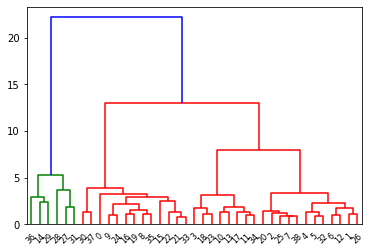

In [ ]:
# dendrogram to have an idea about aggregation procedure
# and the evolution between cluster distance

from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

Z = linkage(packed_data, metric=metric, method=linkage_method)
# fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z)

In [ ]:
# use Calanski-Harabasz index
# to choose the right number of cluster

from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics


# where to store CH index
arr_calanski = {}

# max possible number of cluster
max_k = 10

# data
X = packed_data

# loop over number of clusters
for k in range(2, max_k):
  # build model 
  model = AgglomerativeClustering(n_clusters=k, linkage=linkage_method, affinity=metric)
  model = model.fit(X)

  # clusters label
  labels = model.fit_predict(X)

  # compute calanski metric
  m = metrics.calinski_harabasz_score(X, labels)

  arr_calanski[k] = m


# plot of CH index
fig = go.Figure(data=[
                      go.Scatter(x=list(arr_calanski.keys()), y=list(arr_calanski.values()))
])

fig.update_layout(
    width=800,
    height=500,
    xaxis_title="number of cluster",
    yaxis_title="Calanski-Harbasz index"
)

fig.show()

In [ ]:
X = packed_data

model = AgglomerativeClustering(n_clusters=4, linkage=linkage_method, affinity=metric)
model = model.fit(X)

# clusters label
labels = model.fit_predict(X)

labels

array([2, 1, 1, 3, 1, 1, 1, 1, 2, 2, 3, 3, 1, 3, 0, 2, 2, 3, 3, 2, 1, 2,
       2, 3, 2, 1, 1, 0, 0, 0, 2, 0, 1, 2, 3, 2, 0, 2, 1])